In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
#load data
icu_data = pd.read_csv('icu/icustays_cleaned.csv')
diagnosis = pd.read_csv('ed/diagnosis_cleaned.csv')
triage = pd.read_csv('ed/triage_cleaned.csv')
vitals = pd.read_csv('ed/vitals_cleaned.csv')
ed_stays = pd.read_csv('ed/edstays_cleaned.csv')

# Combine the icd_version and icd_code columns in diagnosis table
diagnosis['icd_combined'] = diagnosis['icd_version'].astype(str) + '-' + diagnosis['icd_code'].astype(str)
print(diagnosis.head())


   subject_id   stay_id  seq_num icd_code  icd_version  \
0    10000032  32952584        1     4589            9   
1    10000032  32952584        2    07070            9   
2    10000032  32952584        3      V08            9   
3    10000032  39399961        1    78097            9   
4    10000032  39399961        2    34830            9   

                                           icd_title icd_combined  
0                                    HYPOTENSION NOS       9-4589  
1  UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...      9-07070  
2                         ASYMPTOMATIC HIV INFECTION        9-V08  
3                             ALTERED MENTAL STATUS       9-78097  
4                        ENCEPHALOPATHY, UNSPECIFIED      9-34830  


Following code links emergency department (ED) stays with ICU admissions and their corresponding length of stay (los). The resulting DataFrame is essential for downstream tasks like predictive modeling or analysis of ICU utilization based on ED visit data.

In [3]:
# Merge datasets
merged_ed_icu = ed_stays[['stay_id', 'hadm_id']].merge(icu_data[['hadm_id', 'los']], on='hadm_id', how='inner')
merged_ed_icu = merged_ed_icu[['stay_id', 'hadm_id', 'los']]

print(merged_ed_icu.head())

    stay_id     hadm_id       los
0  32952584  29079034.0  0.410266
1  39399961  29079034.0  0.410266
2  30905710  26913865.0  0.497535
3  39866888  24597018.0  1.118032
4  34719194  26184834.0  9.171817


#### Processing Vitals Data
In this section, we process the `vitals` data to extract meaningful features that capture both static and dynamic aspects of a patient’s condition during their stay in the emergency department (ED). This approach ensures that the data is prepared for downstream tasks like predictive modeling or analysis. 

#### Why Process Vitals Data This Way?
- Static Aggregates for Overall Trends: The vital signs data (`heartrate`, `resprate`, `o2sat`, `sbp`, `dbp`) often includes multiple time-stamped measurements for each `stay_id`. Aggregating these values into a single `mean` value provides a concise summary of the patient's overall condition during their ED stay.
- Dynamic Trends for Detailed Insights: Aggregates like mean values can overlook significant temporal trends or changes in a patient’s condition. By calculating the slope of each vital sign over time (using linear regression), we capture these trends, such as:
    - Improvement: A patient’s oxygen saturation (o2sat) increases over time.
    - Deterioration: A patient’s blood pressure (sbp, dbp) decreases over time.
    
    These trends are critical for understanding how a patient’s condition evolves and can be strong predictors for downstream analysis (e.g., ICU length of stay).
- Combining Aggregates and Trends: Merging the static (mean, represente as _x) and dynamic (slope, represente as _slope) features ensures that both high-level and fine-grained patterns in the data are included for analysis or modeling.

#### Key Steps in the Code:
1. Aggregate Vitals Data: The `groupby` operation on `stay_id` aggregates vital sign measurements for each patient stay, providing static features like mean values for each vital sign.

2. Calculate Slope for Dynamic Trends: The `calculate_slope` function calculates the rate of change (slope) for each vital sign over time by performing linear regression on the time-stamped data (`charttime`) and the vital sign values.

3. Merge Vitals and Triage Data: Combines the `vitals_summary` data (static features) with the `triage` data using a left join on `stay_id`. `_x` refers to columns from the `triage` dataset. `_y` refers to columns from the `vitals_summary` dataset, which is the `mean` value.

4. Merge Static and Dynamic Features: After aggregating static values and calculating dynamic slopes, dynamic (slope) features are merged with other data to create a comprehensive feature set. 

5. Retain Desired Columns for Further Use: Only the most relevant columns (static aggregates, slopes, and identifiers) are retained for use in downstream analysis.

I think these can be write in the report.

Benefits of This Approach:
- Comprehensive Data Representation: Combining static and dynamic features captures both the overall condition and temporal patterns of a patient’s vitals.
- Improved Predictive Power: Trends (slopes) can highlight critical insights that static features alone cannot reveal, such as rapid deterioration or improvement in a patient’s condition.
- Cleaner, More Organized Dataset: Aggregating and merging the vitals data ensures that the resulting dataset is ready for machine learning models or statistical analysis.

In [4]:
date_format = '%Y-%m-%d %H:%M:%S'

def calculate_slope(df, col):
    df = df.sort_values('charttime').dropna(subset=[col])  # Drop NaN rows
    time_delta = (pd.to_datetime(df['charttime'], format=date_format) - pd.to_datetime(df['charttime'], format=date_format).min()).dt.total_seconds()

    if len(time_delta.unique()) < 2 or df[col].nunique() < 2:
        return np.nan

    slope = np.polyfit(time_delta, df[col], 1)[0]
    return slope


# Aggregate vitals data
vitals_summary = vitals.groupby('stay_id').agg({
    'heartrate': 'mean',
    'resprate': 'mean',
    'o2sat': 'mean',
    'sbp': 'mean',
    'dbp': 'mean'
}).reset_index()

# Calculate slopes
slope_data = vitals.groupby('stay_id').apply(
    lambda x: pd.Series({
        'heartrate_slope': calculate_slope(x, 'heartrate'),
        'resprate_slope': calculate_slope(x, 'resprate'),
        'o2sat_slope': calculate_slope(x, 'o2sat'),
        'sbp_slope': calculate_slope(x, 'sbp'),
        'dbp_slope': calculate_slope(x, 'dbp')
    })
).reset_index()

# Merge triage and vitals summary
merged_features = triage.merge(vitals_summary, on='stay_id', how='left')

# Merge slopes into merged_features
merged_features = merged_features.merge(slope_data, on='stay_id', how='left')

# Retain only desired columns
ed_features = merged_features[[
    'stay_id', 'heartrate_x', 'resprate_x', 'o2sat_x', 'sbp_x', 'dbp_x',
    'heartrate_y', 'resprate_y', 'o2sat_y', 'sbp_y', 'dbp_y', 
    'heartrate_slope', 'resprate_slope', 'o2sat_slope', 'sbp_slope', 'dbp_slope'
]]

# Verify result
print(ed_features.head())


    stay_id  heartrate_x  resprate_x  o2sat_x  sbp_x  dbp_x  heartrate_y  \
0  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
1  39399961         77.0        16.0     98.0   96.0   50.0    85.727273   
2  30905710         80.0        25.0     97.0  132.0   83.0    70.000000   
3  39866888         81.0        16.0     97.0  160.0  102.0    66.666667   
4  34719194         80.0        24.0     98.0  116.0   66.0    84.666667   

   resprate_y     o2sat_y       sbp_y      dbp_y  heartrate_slope  \
0   20.285714   98.000000   79.428571  42.857143         0.000133   
1   16.909091   94.363636   84.181818  50.545455         0.000785   
2   28.000000  100.000000  144.000000  87.000000        -0.001754   
3   16.000000   99.000000  143.666667  97.333333         0.000210   
4   21.166667   94.166667  135.600000  74.000000         0.000001   

   resprate_slope  o2sat_slope  sbp_slope  dbp_slope  
0       -0.000509     0.000099  -0.000282  -0.000404  
1       -0.000081 

/var/folders/x0/6g9d3qsx78gflgy4qv_xd2th0000gn/T/ipykernel_34587/87066971.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slope_data = vitals.groupby('stay_id').apply(


In [5]:
#Merge ED features with ICU and Diagnosis Data
final_data = pd.merge(ed_features, merged_ed_icu[['stay_id', 'hadm_id', 'los']], on='stay_id', how='inner')
final_data = pd.merge(final_data, diagnosis[['stay_id', 'icd_combined']], on='stay_id', how='left')
final_data = pd.merge(final_data, ed_stays[['stay_id', 'intime', 'outtime']], on='stay_id', how='left')

# Verify result
print(final_data.head())

    stay_id  heartrate_x  resprate_x  o2sat_x  sbp_x  dbp_x  heartrate_y  \
0  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
1  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
2  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
3  39399961         77.0        16.0     98.0   96.0   50.0    85.727273   
4  39399961         77.0        16.0     98.0   96.0   50.0    85.727273   

   resprate_y    o2sat_y      sbp_y  ...  heartrate_slope  resprate_slope  \
0   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
1   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
2   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
3   16.909091  94.363636  84.181818  ...         0.000785       -0.000081   
4   16.909091  94.363636  84.181818  ...         0.000785       -0.000081   

   o2sat_slope  sbp_slope  dbp_slope     hadm_id       los  icd_combined  \
0   

In [6]:
# Impute missing values
def impute_missing_values(df, numeric_features, non_numeric_features):
    # Impute numeric columns using the mean
    numeric_imputer = SimpleImputer(strategy='mean')
    df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])
    
    # Impute non-numeric columns with a constant value, e.g., 'unknown'
    non_numeric_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
    df[non_numeric_features] = non_numeric_imputer.fit_transform(df[non_numeric_features])
    
    return df

# Define numeric and non-numeric features for imputation
numeric_features = ['heartrate_x', 'resprate_x', 'o2sat_x', 'sbp_x', 'dbp_x',
                    'heartrate_y', 'resprate_y', 'o2sat_y', 'sbp_y', 'dbp_y', 
                    'heartrate_slope', 'resprate_slope', 'o2sat_slope', 'sbp_slope', 'dbp_slope'
                    ]
non_numeric_features = ['icd_combined']

In [7]:
# Apply the imputation function
final_data = impute_missing_values(final_data, numeric_features, non_numeric_features)

# Function to calculate and handle outliers
def remove_outliers(df, col_ranges):
    for col_prefix, (min_val, max_val) in col_ranges.items():
        # Handle both '_x' and '_y' columns for each vital sign
        for suffix in ['_x', '_y']:
            col = col_prefix + suffix
            if col in df.columns:
                df[col] = np.where(df[col] < min_val, min_val, df[col])
                df[col] = np.where(df[col] > max_val, max_val, df[col])
    return df

# Define column ranges for vital signs
col_ranges = {
    'heartrate': (30, 180),
    'resprate': (8, 60),
    'o2sat': (50, 100),
    'sbp': (60, 250),
    'dbp': (30, 150),
}

# Apply outlier removal
final_data = remove_outliers(final_data, col_ranges)

# Verify result
print(final_data.head())

    stay_id  heartrate_x  resprate_x  o2sat_x  sbp_x  dbp_x  heartrate_y  \
0  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
1  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
2  32952584         87.0        14.0     97.0   71.0   43.0    84.571429   
3  39399961         77.0        16.0     98.0   96.0   50.0    85.727273   
4  39399961         77.0        16.0     98.0   96.0   50.0    85.727273   

   resprate_y    o2sat_y      sbp_y  ...  heartrate_slope  resprate_slope  \
0   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
1   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
2   20.285714  98.000000  79.428571  ...         0.000133       -0.000509   
3   16.909091  94.363636  84.181818  ...         0.000785       -0.000081   
4   16.909091  94.363636  84.181818  ...         0.000785       -0.000081   

   o2sat_slope  sbp_slope  dbp_slope     hadm_id       los  icd_combined  \
0   

In [8]:
# Prepare ED los data for normalization
final_data['intime'] = pd.to_datetime(final_data['intime'])
final_data['outtime'] = pd.to_datetime(final_data['outtime'])
final_data['ed_los'] = (final_data['outtime'] - final_data['intime']).dt.total_seconds() / 3600 # convert to hours

# Normalize data
id_columns = ['stay_id', 'hadm_id', 'icd_combined', 'los']
normalize_cols = ['heartrate_x', 'resprate_x', 'o2sat_x', 'sbp_x', 'dbp_x', 
                  'heartrate_y', 'resprate_y', 'o2sat_y', 'sbp_y', 'dbp_y', 
                  'heartrate_slope', 'resprate_slope', 'o2sat_slope', 'sbp_slope', 'dbp_slope', 'ed_los']

# Separate data into two parts: identifiers and features to normalize
id_data = final_data[id_columns].copy()
features_to_normalize = final_data[normalize_cols].copy()

# Handle missing values in features before normalization
features_to_normalize.fillna(features_to_normalize.mean(), inplace=True)

# Normalize only the numeric columns
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_to_normalize)
normalized_features_df = pd.DataFrame(normalized_features, columns=normalize_cols)

# Concatenate the identifier columns with the normalized features
final_data_normalized = pd.concat([id_data.reset_index(drop=True), normalized_features_df.reset_index(drop=True)], axis=1)

# Handle missing values in non-numeric columns
final_data_normalized['icd_combined'] = final_data_normalized['icd_combined'].fillna('unknown')

# Save the processed data
final_data_normalized.to_csv('preprocessed_data.csv', index=False)
print("Final preprocessed data saved to 'preprocessed_data.csv'")

# Size of final_data_normalized
print(final_data_normalized.shape)

Final preprocessed data saved to 'preprocessed_data.csv'
(75509, 20)


In [9]:
# regression model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the preprocessed data
data = pd.read_csv('preprocessed_data.csv')

# Define features and target
X = data.drop(columns=['stay_id', 'hadm_id', 'icd_combined', 'los', 'ed_los'])
y = data['los']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Calculate the mean squared error
lr_mse = mean_squared_error(y_test, lr_predictions)

print(f'Linear Regression MSE: {lr_mse:.2f}')

# Train a random forest model
rf_model = RandomForestRegressor(n_estimators=250, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)

print(f'Random Forest MSE: {rf_mse:.2f}')

# The commented code tested the effect of the number of trees on the random forest model. Decided on n_estimators = 250 for the final model.

# n_estimators_range = [100, 200, 500]
# mse_values = []
# 
# for n_estimators in n_estimators_range:
#     rf_model = RandomForestRegressor(n_estimators = n_estimators, random_state=42)
#     rf_model.fit(X_train, y_train)
#     rf_predictions = rf_model.predict(X_test)
#     mse = mean_squared_error(y_test, rf_predictions)
#     mse_values.append(mse)
#     print(f'Random Forest (n_estimators={n_estimators}) MSE: {mse:.2f}')
#     
# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(n_estimators_range, mse_values, marker='o')
# plt.xlabel('Number of Trees')
# plt.ylabel('Mean Squared Error')
# plt.title('Effect of Number of Trees on Random Forest Performance')
# plt.grid(True)
# plt.show()

Linear Regression MSE: 24.89
Random Forest MSE: 13.11


In [10]:
# LSTM

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Prepare data for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 10
sequences = create_sequences(data['ed_los'].values, seq_length)

X_lstm = sequences[:, :-1]
y_lstm = data['los'].values[seq_length - 1:]

# Split the data into training and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Reshape the data for LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Build an LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(seq_length, 1)))
lstm_model.add(LSTM(100, activation='relu', return_sequences=True))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_split=0.2)

# Make predictions using the LSTM model
lstm_predictions = lstm_model.predict(X_test_lstm)

# Calculate MSE of LSTM
lstm_mse = mean_squared_error(y_test_lstm, lstm_predictions)
print(f'LSTM Model MSE: {lstm_mse:.2f}')

Epoch 1/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 25.1252 - val_loss: 24.5396
Epoch 2/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 22.6100 - val_loss: 24.6013
Epoch 3/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 23.1107 - val_loss: 24.5123
Epoch 4/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 23.0607 - val_loss: 24.5030
Epoch 5/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 23.5749 - val_loss: 24.5117
Epoch 6/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 23.6361 - val_loss: 24.5579
Epoch 7/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 23.3467 - val_loss: 24.6262
Epoch 8/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 22.9700 - val_loss: 24.5159
Epoch 9/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 23.5488 - val_loss: 24.5035
Epoch 10/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 22.3561 - val_loss: 24.5377
Epoch 11/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 23.4089 - val_loss: 24.5081
Epoch 12

In [11]:
# Calculate the variance of the target variable
target_variance = np.var(y_test)
print(f'Variance of the target variable: {target_variance:.2f}')

# Calculate the MSE of a baseline model (predicting the mean of the target variable)
baseline_predictions = np.full_like(y_test, np.mean(y_test))
baseline_mse = mean_squared_error(y_test, baseline_predictions)
print(f'Baseline Model MSE: {baseline_mse:.2f}')

Variance of the target variable: 24.94
Baseline Model MSE: 24.94


In [12]:
from sklearn.metrics import r2_score

min_length = min(len(rf_predictions), len(lstm_predictions))

rf_predictions = rf_predictions[:min_length]
lstm_predictions = lstm_predictions[:min_length].flatten()

# Combine LSTM and Random Forest Predictions
combined_predictions = (rf_predictions + lstm_predictions) / 2

# Evaluate combined model
combined_mse = mean_squared_error(y_test[:min_length], combined_predictions)
print(f'Combined Model MSE: {combined_mse:.2f}')

# Calculate R-squared for the combined model
r2_combined = r2_score(y_test[:min_length], combined_predictions)
print(f'Combined Model R-squared: {r2_combined:.2f}')

Combined Model MSE: 16.39
Combined Model R-squared: 0.34


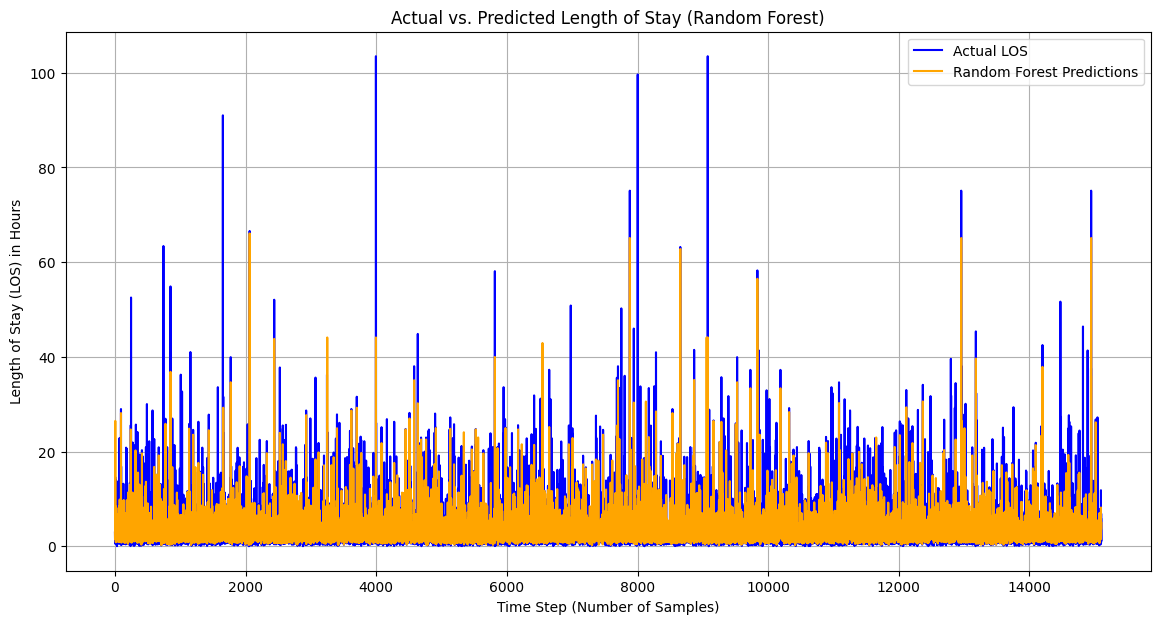

In [13]:
# Plot the actual and predicted LOS values from Random Forest model
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual LOS', color='blue')
plt.plot(rf_predictions, label='Random Forest Predictions', color='orange')
plt.xlabel('Time Step (Number of Samples)')
plt.ylabel('Length of Stay (LOS) in Hours')
plt.title('Actual vs. Predicted Length of Stay (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

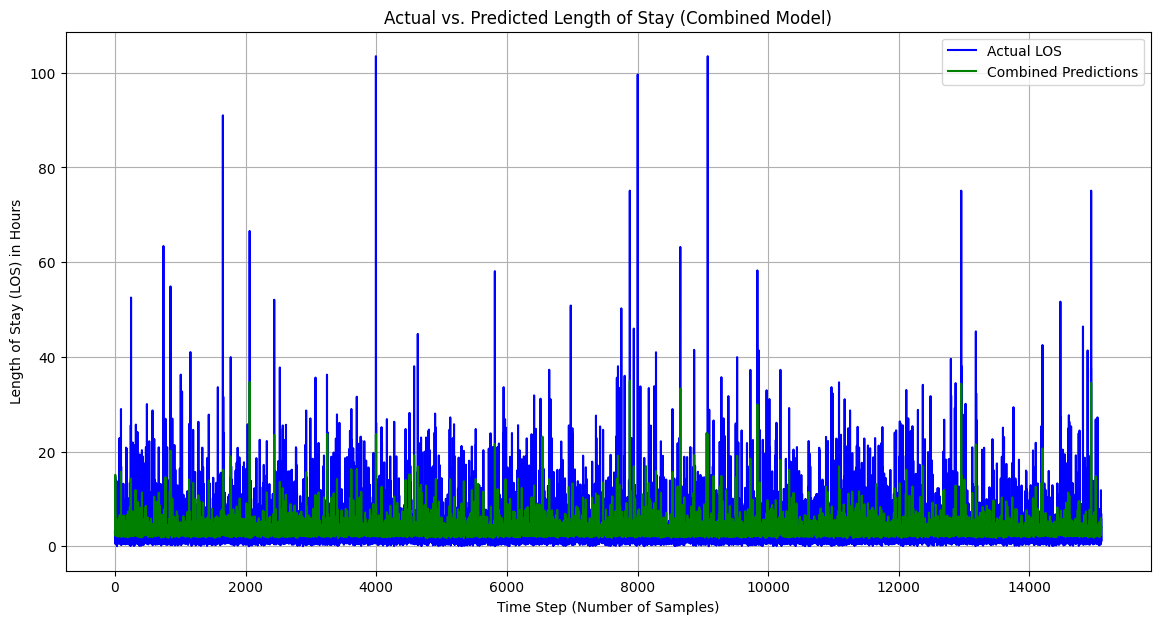

In [14]:
# Plot the actual and predicted LOS values from combined model

plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual LOS', color='blue')
plt.plot(combined_predictions, label='Combined Predictions', color='green')
plt.xlabel('Time Step (Number of Samples)')
plt.ylabel('Length of Stay (LOS) in Hours')
plt.title('Actual vs. Predicted Length of Stay (Combined Model)')
plt.legend()
plt.grid(True)
plt.show()

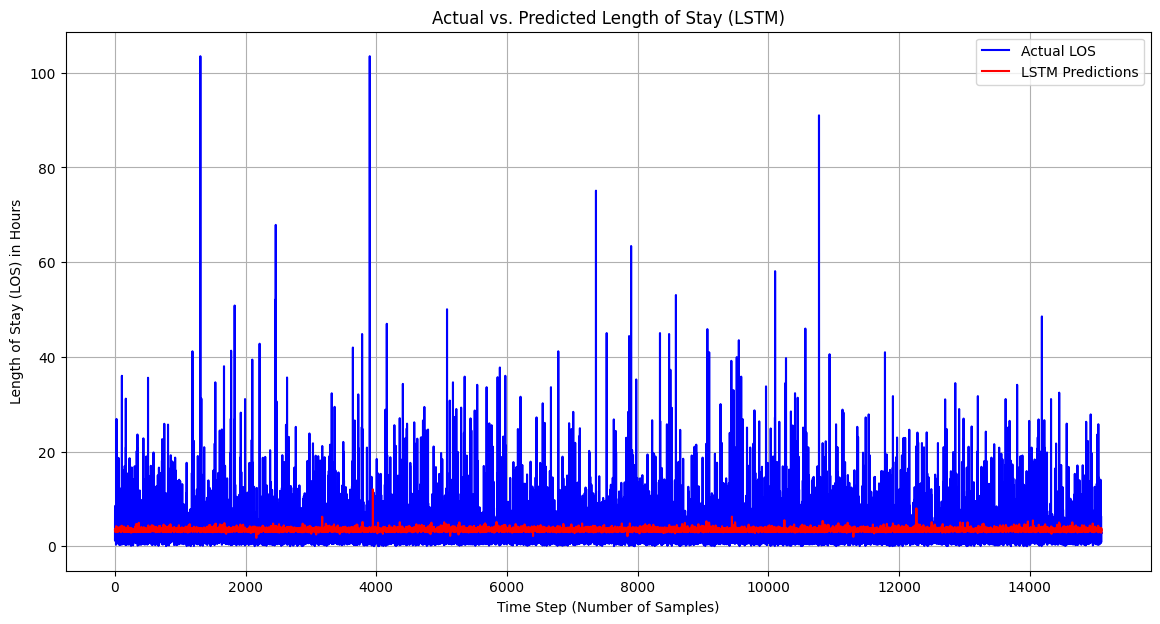

In [15]:
# Plot the actual and predicted LOS values from LSTM model

plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm, label='Actual LOS', color='blue')
plt.plot(lstm_predictions, label='LSTM Predictions', color='red')
plt.xlabel('Time Step (Number of Samples)')
plt.ylabel('Length of Stay (LOS) in Hours')
plt.title('Actual vs. Predicted Length of Stay (LSTM)')
plt.legend()
plt.grid(True)
plt.show()